# OpenQAOA Manual Mode: Plotting Cost Landscapes

This notebook demonstrates the use of OpenQAOA by manual object creations instead of using the pre-defined `QAOA` workflow. Defining circuit objects and backends, using this mode, we will then use these objects to plot cost landscapes of some problem for a $p=1$ circuit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import random_classical_hamiltonian

## Define Cost and Mixer Hamiltonians with ease!

In the previous notebooks we have seen the use of `problem` classes such as `NumberPartition`, `MinimumVertexCover` to define the QUBO problem optimize with QAOA. The workflow automatically translates the QUBO into the corresponding Cost Hamiltonian $H_c$ which defines the cost part of the QAOA ansatz. In this notebook, however, we will bypass the `problem` classes and start with self defined Cost and Mixer Hamiltonians to define our QAOA ansatz.

There are several methods to define a Hamiltonian object:
- We use a utility function built into OpenQAOA to randomly generate a cost Hamiltonian.
- To showcase a more fundamental approach to construct a Hamiltonian, we employ the use of `PauliOp` to construct the $X$-mixer Hamiltonian.

In [2]:
n_qubits = 7
qubit_register = range(n_qubits)
cost_hamiltonian = random_classical_hamiltonian(qubit_register)

In [3]:
# generate the mixer Hamiltonian
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian
pauli_terms = [PauliOp('X',(i,)) for i in qubit_register]
pauli_coeffs = [1]*n_qubits
mixer_hamiltonian = Hamiltonian(pauli_terms,pauli_coeffs,constant=0)

# one could also simply just use a utility function to create the same mixer Hamiltonian as follows
# from openqaoa.utilities import X_mixer_hamiltonian
# mixer_hamiltonian = X_mixer_hamiltonian(n_qubits=3,pauli_coeffs)

## Define QAOA Circuit Parameters

Once we have defined the cost and the mixer Hamiltonians, we have information on constructing the QAOA Ansatz. Specifying the depth $p$, along with the Hamiltonians, one can construct an abstract representation of the QAOA circuit. To achieve this, we use the `QAOACircuitParams` class.

In [4]:
circuit_params_p1 = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=1)
circuit_params_p2 = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=2)

### Define QAOA Variational Parameters
The QAOA Variational Parameters manage the variational angles (for e.g. $\beta$'s, $\gamma$'s) used within the circuit. They provide an easy way to initialize the circuit parameters and switch between different parameterization types, for instance, `AnnealingParams`, `FourierParams`, `ExtendedParams` and others. Enjoying a simple method to update the circuit parameters, they work naturally with classical optimizers as shown in other example notebooks. 

In this notebook, however, we will use the Variational Parameters to construct a simple Cost Landscape for:
- A $p=1$ QAOA circuit using StandardParams
- A $p=2$, $q=1$ QAOA circuit using FourierParams

In [10]:
variate_params_std = create_qaoa_variational_params(circuit_params_p1,'standard','ramp')
variate_params_fourier = create_qaoa_variational_params(circuit_params_p2,'fourier','ramp',q=1)

## Define the Backend of your choice!

Once we have information on the abstract representation of the final circuit, we choose the device of execution and construct the corresponding backend for it. This part is responsible for translating the abstract circuit defined earlier, into a circuit defined using the library of the device provider, for instance, constructing a Qiskit `QuantumCircuit` if the specified device is an IBMQ one.

The two methods required to initialize a backend:
- `create_device`: Lets user specify the device
- `get_qaoa_backend`: Constructs the backend corresponding to the specified device along with some other specific arguments. (Check out the API reference for more information)

**NOTE**: Do not forget to specify user-credentials in order to access cloud based devices.

In [11]:
# call the device to use
device_qiskit = create_device(location = 'local', name = 'qiskit.qasm_simulator')

# initialize the backend with the device and circuit_params
backend_qiskit_p1 = get_qaoa_backend(circuit_params_p1, device_qiskit, n_shots = 500)
backend_qiskit_p2 = get_qaoa_backend(circuit_params_p2, device_qiskit, n_shots = 500)

## Construct Cost Landscapes
Evaluate `expectation` value to construct the cost landscapes for both the parameterizations. For this purpose, we define a helper function that computes the value of each pair of angles on the grid, ($\beta_0, \gamma_0$) for StandardParams and ($v_0, u_0$) for FourierParams.

In [12]:
# helper function to produce the cost landscape
def plot_cost_landscape(mixer_angle_iter, cost_angle_iter, variational_params, backend):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    Parameters
    ----------
    
    """
    cost_landscape = np.zeros((mixer_angle_iter.size,mixer_angle_iter.size),dtype=float)
    
    for i,mixer_angle in enumerate(mixer_angle_iter):
        for j,cost_angle in enumerate(cost_angle_iter):
            variational_params.update_from_raw([mixer_angle,cost_angle])
            cost_landscape[i,j] = backend.expectation(variational_params)
            
    return cost_landscape

In [13]:
# cost landscape for standard parameterization
gammas = np.linspace(-np,2*np.pi,50)
betas = np.linspace(0,np.pi,50)

cost_landscape_std = plot_cost_landscape(betas, gammas, variate_params_std, backend_qiskit_p1)

# cost landscape for Fourier parameterization
us = np.linspace(0,2*np.pi,50)
vs = np.linspace(0,np.pi,50)

cost_landscape_fourier = plot_cost_landscape(vs, us, variate_params_fourier, backend_qiskit_p2)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


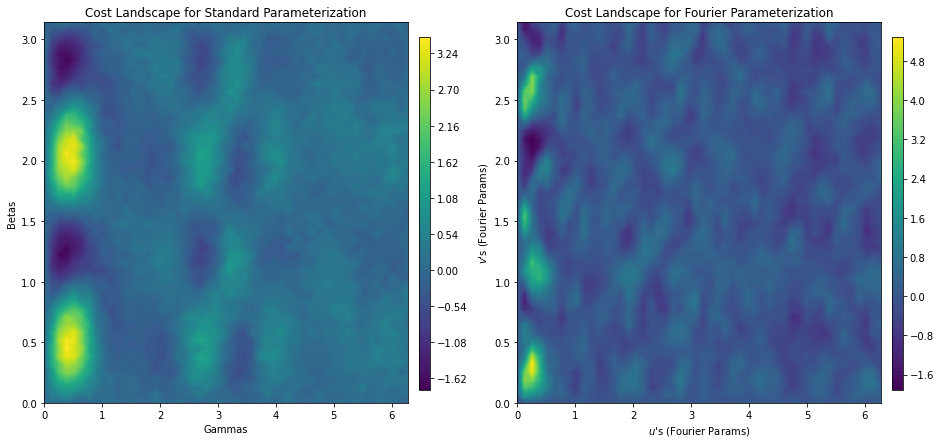

In [70]:
fig,axes = plt.subplots(1,2,sharex = False, sharey=False,figsize=(15,7),gridspec_kw={'wspace': 0.3})
cmap = 'viridis'

im_0 = axes[0].contourf(cost_landscape_std,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[0].set_title('Cost Landscape for Standard Parameterization')
axes[0].set_xlabel('Gammas')
axes[0].set_ylabel('Betas')

cbar_ax = fig.add_axes([0.472, 0.15, 0.01, 0.7])
fig.colorbar(im_0, cax=cbar_ax)

im_1 = axes[1].contourf(cost_landscape_fourier,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[1].set_title('Cost Landscape for Fourier Parameterization')
axes[1].set_xlabel("$u$'s (Fourier Params)")
axes[1].set_ylabel("$v$'s (Fourier Params)")

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im_1, cax=cbar_ax);